<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [1]:
from utils import *
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

## **1.1** Datasets

In [3]:
# Load the train/val split data
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Store the data in variables
x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [4]:
# For EXTRA

# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

## **1.2** Parameters

In [5]:
# ------- Parameters -------
# Glove
emb_size = 200 # start small than increase to find the best value

# TF-IDF
max_df = 0.8 # we are removing terms that appear in >80% of tweets

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

## **1.3** General

In [6]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

vector_size = max(train_len)

metrics_df = []

In [7]:
import nltk
nltk.download('punkt', download_dir='/Users/mgalao/nltk_data')
nltk.data.path.append('/Users/mgalao/nltk_data')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/mgalao/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
max_seq_len = max(len(tokens) for tokens in tokenized_train)

## **1.4** Models

### Glove

In [ ]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

### Text Embeddings 3 Small

In [ ]:
# EXTRA

# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

In [ ]:
# Define embedding model text embedding
model_te3s = "text-embedding-3-small"

### Roberta

In [ ]:
# Load the pre-trained model and tokenizer for roberta
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)

### LSTM

In [ ]:
input_ = Input(shape=(max_seq_len, vector_size))

x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

<div class="alert alert-block alert-success">

# **2.** **Retrain Best Model**
LR with Twitter Roberta (Extra) Embeddings

<div>

<div class="alert alert-block alert-success">

# **3.** **Final Predictions**

<div>

## **5.6** Twitter Roberta Base - EXTRA

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_roberta_embeddings.pkl", 
                                                                 cache_file_val="X_val_roberta_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading RoBERTa embeddings from X_train_roberta_embeddings.pkl...
Loading RoBERTa embeddings from X_val_roberta_embeddings.pkl...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Define the title for the metrics and plots
title = "Logistic Regression with RoBERTa"

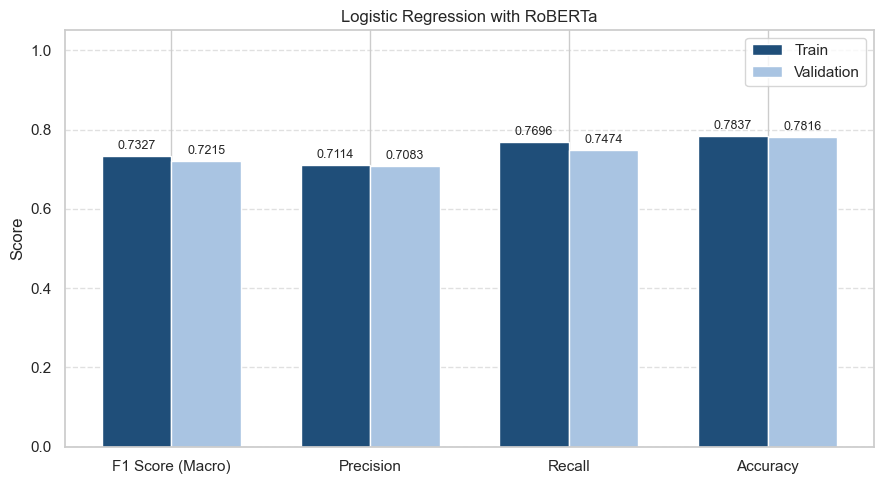

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

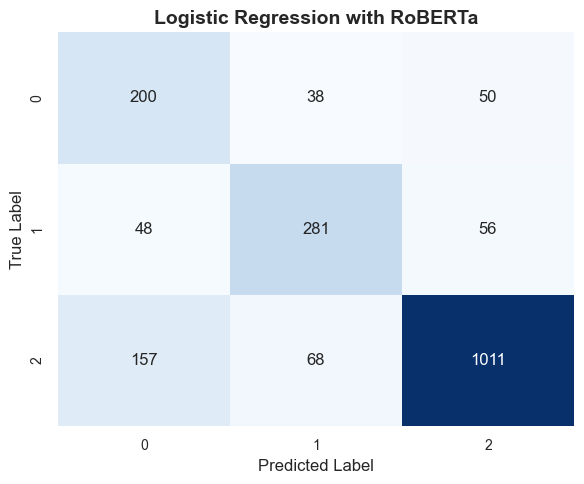

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

In [ ]:
# Load the test dataset
test_data = pd.read_csv("../data/test.csv")
test_texts = test_data["text"].tolist()

# Get embeddings for test set
X_test_roberta = np.array(get_roberta_embeddings(train_texts, "X_test_roberta_embeddings.pkl", batch_size=32, force_reload=False))

In [ ]:
# Predict labels with the trained classifier
X_test_te3s_pred = clf_roberta_lr.predict(X_test_te3s)

# Create submission DataFrame
submission_te3s = pd.DataFrame({
    "id": test_data["id"],
    "label": X_test_roberta_pred
})

# Save submission to CSV
submission_te3s.to_csv("roberta_lr_pred_25.csv", index=False)
print("Submission file saved as roberta_lr_pred_25.csv")

In [ ]:
# Load the predictions from the saved CSV file
pred_25 = pd.read_csv("roberta_lr_pred_25.csv")
pred_25.head()